In [9]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import seaborn as sns

# función propia de agrepación de datos censales por tramos de edad
from functions.agrupar_dfs_censo import agrupar_por_tramos

In [10]:
metadatos_figs = {'Author': '''Guillermo D'Angelo''',
                  'Title': 'Pirámide de población Censo INE 2011'}

In [11]:
# levanta datos censales
censo = pd.read_csv('tablas/personas_censo_2011.gz', compression='gzip', header=0, sep=',', quotechar='"')
# reemplaza el valor 5555 en edad (variable PERNA01) por NaNs
censo.loc[censo.PERNA01 == 5555, 'PERNA01'] = np.nan

In [12]:
censo.head(2)

,DPTO,LOC,SECC,SEGM,PERPH02,PERNA01,PERNA02,PERMI01,PERMI01_1,PERMI01_2,...,PERED02_4,PERED03_R,PERED03_1,PERED03_2,PERED04_R,PERED05_R,PERED06_R,CODIGO_CAR,PERED08,NIVELEDU_R
0,1,20,1,1,2,22.0,1988-11-01,1,NaN,NaN,...,0,0,4,0,1,3,0,22101,1,4
1,1,20,1,1,2,84.0,1927-07-01,1,NaN,NaN,...,0,0,2,0,2,2,0,11101,2,2


#### Subset del DF Censo, sólo con los migrantes internos

In [13]:
# define vector de nombres de columnas para filtrar
cols = ['DPTO','LOC', 'SECC', 'SEGM',
        'PERPH02', 'PERNA01', 'PERMI07', 'PERMI07_1', 
        'PERMI07_2', 'PERMI07_3', 'PERMI07_4']

# filtra
# p_migr = censo[(censo.PERMI07 == 2) | (censo.PERMI07 == 3)][cols]

# en un principio se aplicó el filtro anterior, luego se pasó a
# sólo los mgirantes interdepartamentales, para seguir el criterio
# definido en la metodología
mgr_interdep = censo.loc[(censo.PERMI07 == 3), cols].copy()

# identifica depto de residencia anterior
mgr_interdep['depto_origen'] = mgr_interdep.loc[:,('PERMI07_2')]
mgr_interdep.depto_origen.fillna(mgr_interdep.DPTO, inplace=True)

# # convierte a integer
mgr_interdep.loc[:,('depto_origen')] = mgr_interdep.loc[:,('depto_origen')].astype(int)

# # renombra DPTO
mgr_interdep.rename(columns={'DPTO': 'depto_destino'}, inplace=True)

mgr_interdep.head()

,depto_destino,LOC,SECC,SEGM,PERPH02,PERNA01,PERMI07,PERMI07_1,PERMI07_2,PERMI07_3,PERMI07_4,depto_origen
5,1,20,1,1,1,24.0,3,NaN,3.0,732.0,0,3
40,1,20,1,1,2,22.0,3,NaN,17.0,220.0,0,17
50,1,20,1,1,1,19.0,3,NaN,18.0,220.0,0,18
64,1,20,1,1,1,24.0,3,NaN,2.0,220.0,0,2
110,1,20,1,1,2,28.0,3,NaN,12.0,320.0,0,12


#### Agrupación de ambos DFs

In [14]:
censo_group, migrantes_group = [agrupar_por_tramos(x,'tramo', 'PERNA01','PERPH02') for x in [censo, mgr_interdep]]

In [15]:
print(censo_group.head())
print(migrantes_group.head())

   sexo  tramo  personas  porc_pers sexo_label
0     1    +95      -806  -0.024530    varones
1     1    0-4   -112701  -3.429916    varones
2     1  10-14   -131018  -3.987371    varones
3     1  15-19   -133041  -4.048939    varones
4     1  20-24   -119928  -3.649861    varones
   sexo  tramo  personas  porc_pers sexo_label
0     1    +95       -21  -0.014117    varones
1     1  10-14     -5234  -3.518443    varones
2     1  15-19     -6785  -4.561069    varones
3     1  20-24    -11190  -7.522234    varones
4     1  25-29     -8301  -5.580167    varones


In [16]:
# función para graficar
def bars_pyramid(df, axis):
    "Grafica barras para pirámdes"
    for c, group in zip(colors, df[group_col].unique()):
        sns.barplot(x='porc_pers',
                    y='tramo',
                    data=df.loc[df[group_col]==group, :],
                    order = order_of_bars,
                    color=c,
                    label=group,
                    ax=axis)

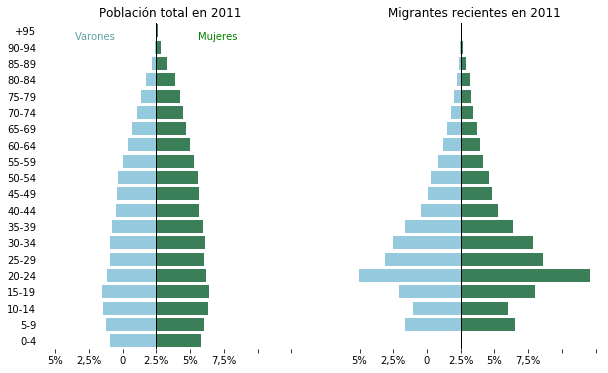

In [17]:
# pirámides de población

# dos ejes
fig, (ax1, ax2)  = plt.subplots(1,2, figsize= (10, 6), sharex= True, sharey='row')

# vector de etiquetas para cada tramo
labels = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
          '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '+95']

# plot
group_col = 'sexo_label'
order_of_bars = labels[::-1]
colors = ['skyblue', 'seagreen']
label=['sexo', 'sasa']

# aplica función para graficar
bars_pyramid(censo_group, ax1)
bars_pyramid(migrantes_group, ax2)

# títulos
ax1.set_title('Población total en 2011')
ax2.set_title('Migrantes recientes en 2011')

# etiquetas
x_ticks_labels = ['7,5','5%','2,5%','0','2.5%','5%','7,5%']

# parámetros gráficos
for i in [ax1, ax2]:
    i.set_axisbelow(True)
    i.set_ylabel(None)
    i.set_xlabel(None)
    i.axvline(linewidth=1, color='black')
    i.set_xticklabels(x_ticks_labels)
    [s.set_visible(False) for s in i.spines.values()]
    [t.set_visible(False) for t in i.get_yticklines()]
    
# chirimbolos
ax1.text(-6, 0.5, 'Varones',
        horizontalalignment='left',
        color='cadetblue', fontsize=10)

ax1.text(6, 0.5, 'Mujeres',
        horizontalalignment='right',
        color='green', fontsize=10)

# plt.savefig('mapas_graficas/001_poblacion_vs_migrantes.pdf',
#              bbox_inches= 'tight',
#              metadata= metadatos_figs)

plt.show()

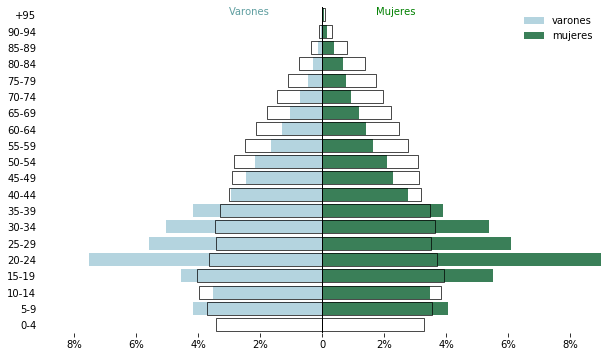

In [18]:
# pirámides de población solapadas
fig, ax  = plt.subplots(1, figsize= ( 10, 6 ))

# plot
group_col = 'sexo_label'
order_of_bars = labels[::-1]
colors = ['lightblue', 'seagreen']
label=['sexo', 'sasa']

bars_pyramid(migrantes_group, ax)

for c, group in zip(colors, migrantes_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo',
                data=censo_group.loc[censo_group[group_col]==group, :],
                order = order_of_bars,
                fill=False,
                linewidth = 0.7,
                edgecolor='black',
                ax=ax)

ax.set_axisbelow(True)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.axvline(linewidth=1, color='black')
ax.set_xlim([-9,9])
ax.set_xticklabels(['10%','8%','6%','4%','2%','0','2%','4%','6%','8%'])

[s.set_visible(False) for s in ax.spines.values()]
[t.set_visible(False) for t in ax.get_yticklines()]
    
ax.text(-3, 0, 'Varones',
        horizontalalignment='left',
        color='cadetblue', fontsize=10)

ax.text(3, 0, 'Mujeres',
        horizontalalignment='right',
        color='green', fontsize=10)

plt.savefig('mapas_graficas/002_piramide_mig.pdf',
             bbox_inches='tight',
             metadata = metadatos_figs)

ax.legend(loc='upper right', frameon=False)

plt.show()

In [19]:
# destino Mvdeo.
a = mgr_interdep[mgr_interdep.depto_destino == 1]

# origen Mvdeo. y destino no Mvdeo.
b = mgr_interdep[(mgr_interdep.depto_origen == 1) & (mgr_interdep.depto_destino != 1)]

# origen y destino no Mvdeo.
c = mgr_interdep[(mgr_interdep.depto_origen != 1) & (mgr_interdep.depto_destino != 1)]

# enlista los tres dataframes
lista_dfs = [a, b, c]

In [20]:
mgr_interdep.head()

,depto_destino,LOC,SECC,SEGM,PERPH02,PERNA01,PERMI07,PERMI07_1,PERMI07_2,PERMI07_3,PERMI07_4,depto_origen,tramo
5,1,20,1,1,1,24.0,3,NaN,3.0,732.0,0,3,20-24
40,1,20,1,1,2,22.0,3,NaN,17.0,220.0,0,17,20-24
50,1,20,1,1,1,19.0,3,NaN,18.0,220.0,0,18,15-19
64,1,20,1,1,1,24.0,3,NaN,2.0,220.0,0,2,20-24
110,1,20,1,1,2,28.0,3,NaN,12.0,320.0,0,12,25-29


In [23]:
# genera dataframes por tipología
def filter_df_mig(df, ver_dep_ori, var_dep_des):
    "Corta DFs según origen y destino de la migración"
    # destino Mvdeo.
    a = df[df[var_dep_des] == 1].copy()
    # origen Mvdeo. y destino no Mvdeo.
    b = df[(df[ver_dep_ori] == 1) & (df[var_dep_des] != 1)].copy()
    # origen y destino no Mvdeo.
    c = df[(df[ver_dep_ori] != 1) & (df[var_dep_des] != 1)].copy()
    
    return a, b, c

# aplica función
a, b, c = filter_df_mig(mgr_interdep, 'depto_origen', 'depto_destino')

# enlista los tres DFs
lista_dfs = [a, b, c]

# agrupa los tres DFs
a_group, b_group, c_group = [agrupar_por_tramos(x, 'tramo', 'PERNA01', 'PERPH02') for x in lista_dfs]

# vector de titulos de gráficas
titles = ['Hacia Montevideo',
          'Desde Montevideo al interior',
          'Entre departamentos del interior']

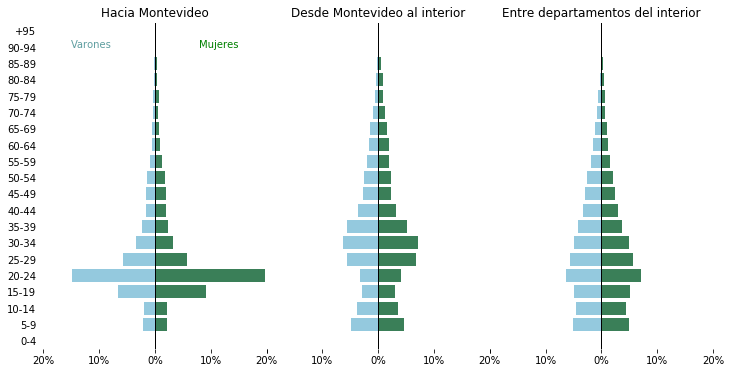

In [24]:
# pirámides de población
# tres ejes
fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize= ( 12, 6 ), sharex= False, sharey='row')

plt.subplots_adjust(wspace=0)

# plot
group_col = 'sexo_label'
order_of_bars = labels[::-1]
colors = ['skyblue', 'seagreen']
label=['sexo', 'sasa']

bars_pyramid(a_group, ax1)
bars_pyramid(b_group, ax2)
bars_pyramid(c_group, ax3)

ax1.set_title(titles[0])
ax2.set_title(titles[1])
ax3.set_title(titles[2])

for i in [ax1, ax2, ax3]:
    i.set_axisbelow(True)
    i.axvline(linewidth=1, color='black')
    i.set_xlim([-20,20])
    i.set_xlabel(None)
    i.set_ylabel(None)
    [s.set_visible(False) for s in i.spines.values()]
    [t.set_visible(False) for t in i.get_yticklines()]

x_ticks_labels = ['20%','10%','0%','10%','20%']

ax1.set_xticklabels(x_ticks_labels)
ax2.set_xticklabels(['','10%','0%','10%',''])
ax3.set_xticklabels(x_ticks_labels)

ax1.text(-15, 1, 'Varones',
        horizontalalignment='left',
        color='cadetblue', fontsize=10)

ax1.text(15, 1, 'Mujeres',
        horizontalalignment='right',
        color='green', fontsize=10)

plt.savefig('mapas_graficas/003_piramides_mig_recientes.pdf',
             bbox_inches='tight',
             metadata = metadatos_figs)

plt.show()

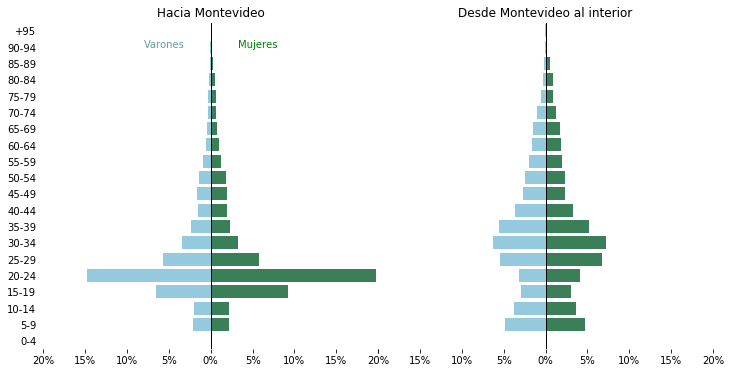

In [25]:
# pirámides de población

# dos ejes
fig, (ax1, ax2)  = plt.subplots(1,2, figsize= ( 12, 6 ), sharex= False, sharey='row')

plt.subplots_adjust(wspace=0)

# plot
group_col = 'sexo_label'
order_of_bars = labels[::-1]
colors = ['skyblue', 'seagreen']
label=['sexo', 'sasa']

bars_pyramid(a_group, ax1)
bars_pyramid(b_group, ax2)

ax1.set_title(titles[0])
ax2.set_title(titles[1])

for i in [ax1, ax2]:
    i.set_ylabel(None)
    i.set_xlabel(None)
    i.set_axisbelow(True)
    i.axvline(linewidth=1, color='black')
    i.set_xlim([-20,20])
    [s.set_visible(False) for s in i.spines.values()]
    [t.set_visible(False) for t in i.get_yticklines()]
    
x_ticks_labels = ['20%','15%','10%','5%','0%','5%','10%','15%','20%']

ax1.set_xticklabels(x_ticks_labels)
ax2.set_xticklabels([''] + x_ticks_labels[1:])

ax1.text(-8, 1, 'Varones',
         horizontalalignment='left',
         color='cadetblue', fontsize=10)

ax1.text(8, 1, 'Mujeres',
         horizontalalignment='right',
         color='green', fontsize=10)

plt.savefig('mapas_graficas/004_piramides_mig_recientes_desde_a_mvdeo.pdf',
             bbox_inches='tight',
             metadata= metadatos_figs )

plt.show()